In [ ]:
# Notebook for creating DoG filters

# Approach

# Define sobel
# Define gaussian of suitable size
# Convolve sobel in x direction with Gaussian
# Rotate for 16 orientations between 0 and 360 degrees
# Repeat process for a different sigma
# Return filters
# Visualize

In [9]:
import numpy as np
from typing import List
from numpy import sqrt, pi, reshape, sin, cos
import matplotlib.pyplot as plt
import cv2

In [10]:
sobel_x = np.array([[+1, 0, -1], [+2, 0, -2], [+1, 0, -1]])
# sobel_y = sobel_x.T 

In [23]:
def get_2d_gaussian(grid: [List[List[float]]], sigma, elong_factor: float = 1) -> [List[List[float]]]:
    """
    Calculates 2d gaussian using function defn. at each point (x, y) in grid
    """
    x, y = grid[0], grid[1]

    sigma_y = sigma
    sigma_x = elong_factor * sigma_y

    num = np.exp(-0.5 * ((x**2 / sigma_x**2) + (y ** 2 / sigma_y**2)))
    denom = np.sqrt(2 * pi * sigma_x * sigma_y)

    return num / denom

In [24]:
# Viz. gaussian

sigma = sqrt(2)

size = 7
bound = (size - 1) / 2
spread = np.linspace(-bound, bound, size)
x, y = np.meshgrid(spread, spread)
pts = [x.flatten(), y.flatten()]

gaussian = get_2d_gaussian(pts, sigma)
gaussian = reshape(gaussian, (7, 7))


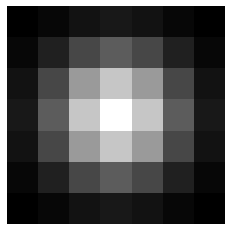

In [25]:
plt.subplot(1,1,1)
plt.axis('off')
plt.imshow(gaussian, cmap = 'gray')

In [26]:
Gx = cv2.filter2D(src=gaussian, ddepth = -1, kernel=sobel_x)

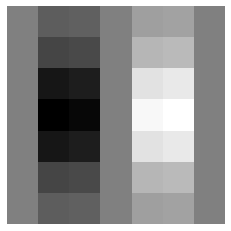

In [27]:
plt.subplot(1,1,1)
plt.axis('off')
plt.imshow(Gx, cmap = 'gray')

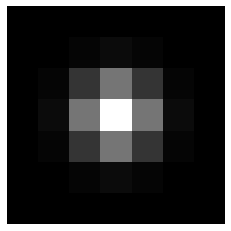

In [28]:
# Get oriented derivative

sigma = 0.8
angle = 11 * pi / orientations

rotation_mat = np.array([[cos(angle), -sin(angle)], [sin(angle), cos(angle)]])
rotated_pts = rotation_mat.dot(pts)
gaussian = get_2d_gaussian(rotated_pts, sigma)
gaussian = reshape(gaussian, (7, 7))

plt.subplot(1,1,1)
plt.axis('off')
plt.imshow(gaussian, cmap = 'gray')


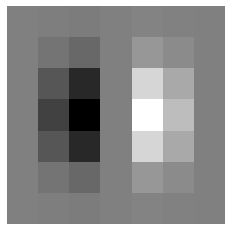

In [29]:
Gx = cv2.filter2D(src=gaussian, ddepth = -1, kernel=sobel_x)

plt.subplot(1,1,1)
plt.axis('off')
plt.imshow(Gx, cmap = 'gray')

In [35]:
# DoG filter bank

# sigma_scales = [sqrt(2), 2]
sigma_scales = [1, 1.4]

angles = 16

size = 7
filter_shape = (size, size)
bound = (size - 1) / 2
spread = np.linspace(-bound, bound, size)
x, y = np.meshgrid(spread, spread)
pts = [x.flatten(), y.flatten()]

center = (int(size/2), int(size/2))

DoGs = []
for sigma in sigma_scales:
    g = get_2d_gaussian(pts, sigma)
    g_2d = reshape(g, filter_shape)
    g_convolved = cv2.filter2D(src=g_2d, ddepth = -1, kernel=sobel_x)
    
    for i in range(angles):
        angle = i * 360 / angles
        rotation_mat = cv2.getRotationMatrix2D(center=center, angle=angle, scale=1)
        dog_filter = cv2.warpAffine(src=g_convolved, M=rotation_mat, dsize=filter_shape)
        DoGs.append(dog_filter)

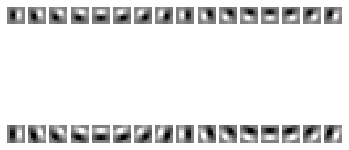

In [36]:
for i in range(len(DoGs)):
    plt.subplot(2,16,i+1)
    plt.axis('off')
    plt.imshow(DoGs[i], cmap = 'gray')

In [41]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

kernel_size = 49

def get_1d_gaussian(x: List[float], sigma: float) -> List[float]:
    """
    Calculates 1d gaussian using function definition at each point in x
    """
#     x = x - np.mean(x)
    
    x = np.array(x)
    
    var = sigma**2
    
    num = np.exp(-(x**2) / 2 * var)
    denom = np.sqrt(2 * pi * var)

    return num / denom

def get_deriv_of_1d_gaussian(order: int, x: List[float], sigma: float) -> List[float]:
    """
    Gets the 1st or 2nd order derivative of gaussian.
    """
    var = sigma**2
    g = get_1d_gaussian(x, sigma)

    if order == 1:
        return -g * (x / var) 
    else:  # order = 2
        return  g * (((x**2) - var) / (var**2))

def get_filter(order: int, pts: List[List[float]], sigma: float):
    """
    Gets the 1st or 2nd order derivative of gaussian.
    """
    gx = get_1d_gaussian(pts[0], 3*sigma)
    gy = get_deriv_of_1d_gaussian(order, pts[1], sigma)

    return np.reshape(gx * gy, (kernel_size, kernel_size))

# def makefilter(scale, phasex, phasey, pts, sup):

    
    
#     gx = gaussian1d(3*scale, 0, pts[0,...], phasex)
#     gy = gaussian1d(scale,   0, pts[1,...], phasey)

#     image = gx*gy

#     image = np.reshape(image,(sup,sup))
#     return image

def makeLMfilters():
    sup     = 49
    scalex  = np.sqrt(2) * np.array([1,2,3])
    norient = 6
    nrotinv = 12

    nbar  = len(scalex)*norient
    nedge = len(scalex)*norient
    nf    = nbar+nedge+nrotinv
    F     = np.zeros([sup,sup,nf])
    hsup  = (sup - 1)/2

    x = [np.arange(-hsup,hsup+1)]
    y = [np.arange(-hsup,hsup+1)]

    [x,y] = np.meshgrid(x,y)

    orgpts = [x.flatten(), y.flatten()]
    orgpts = np.array(orgpts)

    count = 0
    for scale in range(len(scalex)):
        for orient in range(norient):
            angle = (np.pi * orient)/norient
            print(angle)
            c = np.cos(angle)
            s = np.sin(angle)
            rotpts = [[c+0,-s+0],[s+0,c+0]]
            rotpts = np.array(rotpts)
            rotpts = np.dot(rotpts,orgpts)
            
#             F[:,:,count] = makefilter(scalex[scale], 0, 1, rotpts, sup)
#             F[:,:,count+nedge] = makefilter(scalex[scale], 0, 2, rotpts, sup)
            F[:,:,count] = get_filter(1, rotpts, scalex[scale])
    
            import pprint
            pprint.pprint(F[:,:,count])
            
            break    
    
            F[:,:,count+nedge] = get_filter(2, rotpts, scalex[scale])
            count = count + 1

    count = nbar+nedge
    scales = np.sqrt(2) * np.array([1,2,3,4])

#     for i in range(len(scales)):
#         F[:,:,count]   = gaussian2d(sup, scales[i])
#         count = count + 1

#     for i in range(len(scales)):
#         F[:,:,count] = log2d(sup, scales[i])
#         count = count + 1

#     for i in range(len(scales)):
#         F[:,:,count] = log2d(sup, 3*scales[i])
#         count = count + 1

    return F

# Call the make filter function
F = makeLMfilters()
print(F.shape)

0.0
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]])
0.0
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]])
0.0
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]])
(49, 49, 48)


In [ ]:
plt.axis('off')
plt.imshow(F[:,:,0], cmap = 'gray')